______________________________________
# <center>**Trabajo Practico Nº2 para la Materia *Organización de Datos***</center>

*Integrantes*:
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022

Datos provistos por [properati](https://www.properati.com.ar).
______________________________________


## Introducción

El presente trabajo práctico es una continuación del ‘TP1: Propiedades en Venta’. 

En la entrega anterior se propuso aplicar técnicas de análisis exploratorio, preprocesamiento de datos, agrupamiento, clasificación y regresión. Siguiendo esta línea, y con el objetivo de continuar resolviendo problemas reales de ciencia de datos, en esta segunda parte se implementarán nuevos modelos predictivos a partir de los anteriormente mencionados. 

En esta oportunidad se buscará demostrar los conocimientos adquiridos sobre procesamiento del lenguaje natural, redes neuronales y ensamble de modelos. Para esto se utilizarán tanto datasets provistos por la materia, tomados de la página de la empresa Properati, como los generados por el grupo en el trabajo anterior.

## 0. Setup

### Importación de bibliotecas

In [1]:
pip install visualkeras scikeras[tensorflow] scikeras[tensorflow-cpu] unidecode types-all tensorflow keras

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.1 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyclustertend 1.6.2 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.2.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [13]:
#Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from xgboost import XGBRegressor
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from collections import Counter
import unidecode
import re
from joblib import load, dump
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from collections import defaultdict
import math
from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import joblib
#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

if IN_COLAB :
    from google.colab import drive
    drive.mount('/content/drive')

    properati = pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/1d_df_reducido.csv')
    properati_descrip = pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021_decrip.csv')
    stop_words = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/stopwords.txt'
else:
    df_train = pd.read_csv('./DATASETS/df_train_tp1.csv')
    df_test = pd.read_csv('./DATASETS/df_test_tp1.csv')
    properati_descrip = pd.read_csv('properati_argentina_2021_decrip.csv')
    stop_words = 'stopwords'

### Funciones auxiliares

In [14]:
def metricas_clasificacion(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

In [15]:
def prediccion_y_metricas_regresion(regressor, x_test, y_test):

  y_pred = regressor.predict(x_test)

  print(f"Se obtuvo un Score de {round(regressor.score(x_test, y_test)*100,3)}%")

  mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

  print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

  rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

  print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

  return

In [16]:
def format_aspects(line, word):
    format = r"\W*([\w]+)"
    n = 2
    x = re.search(r'{}\W*{}{}'.format(format*n, word, format*n), line)
    if x is not None:
        return x.group()
    else:
        return ""

In [17]:
def convert_b_m_a(x):
    mx = max(x[0], x[1], x[2])
    if mx == x[0]:
        return 'bajo'
    elif mx == x[1]:
        return 'medio'
    elif mx == x[2]:
        return 'alto'

In [18]:
def estandarizar(df, columns):
  sscaler = StandardScaler()

  for col in columns:
    df[col] = sscaler.fit_transform(pd.DataFrame(df[col]))

In [19]:
def limpiar_values_de_aspects(df, aspects, values):
    i = 0
    for aspect in aspects:
        for word in values[i]:
            df[aspect] = df[aspect].apply(lambda line: word if word in line else line)
        df[aspect] = df[aspect].apply(lambda line: line if len(line.split())<2 else '')
        i = i+1

In [20]:
def evaluate_model(model, x, y, splits, n):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=n, random_state=1)
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [21]:
import plotly.graph_objects as go

def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Error Cuadrático Medio',
    showlegend=False)
    fig.show()

### Preparación de datasets

In [22]:
df_train_x = df_train.drop(["property_price", "tipo_precio_3"], axis="columns")
df_train_y_regresion = df_train["property_price"]
df_train_y_clasificacion = df_train["tipo_precio_3"]

df_test_x = df_test.drop(["property_price", "tipo_precio_3"], axis="columns")
df_test_y_regresion = df_test["property_price"]
df_test_y_clasificacion = df_test["tipo_precio_3"]

## 1. Procesamiento del Lenguaje Natural

### 1.a Ampliación del dataset
___

Hacemos un merge del dataset original y el de descripciones, y quedémonos únicamente con las columnas `id` y `property_description`:

In [23]:
df_descrip = pd.merge(df_train_x, properati_descrip, on="id")
df_descrip = df_descrip[["id", "property_description"]]

df_test_descrip = pd.merge(df_test_x, properati_descrip, on="id")
df_test_descrip = df_test_descrip[["id", "property_description"]]

Busquemos aspectos de una propiedad utilizando la columna `property_description`.

Veamos cuántos registros nulos existen:

In [24]:
print(f"Hay {df_descrip['property_description'].isna().sum()} datos nulos.")

Hay 0 datos nulos.


Veamos cuáles son las 100 palabras más comunes en el campo de descripción de propiedades:

In [25]:
Counter(" ".join(df_descrip["property_description"]).split()).most_common(100)

[('de', 857976),
 ('y', 507778),
 ('con', 401867),
 ('la', 290195),
 ('en', 278176),
 ('a', 243751),
 ('el', 169952),
 ('del', 153279),
 ('que', 140055),
 ('por', 133635),
 ('al', 125215),
 ('-', 113875),
 ('un', 103716),
 ('las', 90713),
 ('los', 88435),
 ('para', 88190),
 ('se', 63109),
 ('DE', 56457),
 ('son', 56420),
 ('2', 52790),
 ('es', 50384),
 ('una', 48927),
 ('3', 41258),
 ('cocina', 38889),
 ('ambientes', 38848),
 ('valor', 38420),
 ('esta', 38292),
 ('muy', 36893),
 ('x', 36800),
 ('Av.', 36630),
 ('comedor', 35535),
 ('baño', 35476),
 ('Y', 34141),
 ('CON', 33915),
 ('no', 33912),
 ('piso', 33348),
 ('o', 33050),
 ('/', 32253),
 ('tu', 32101),
 ('A', 32063),
 ('hasta', 30269),
 ('balcón', 29805),
 ('inmueble', 28725),
 ('casa', 28655),
 ('No', 28635),
 ('propiedad.', 28070),
 ('30%', 27684),
 ('departamento', 27670),
 ('EN', 27267),
 ('cuadras', 27069),
 ('Corredor', 26991),
 ('préstamo', 26920),
 ('cuota', 26780),
 ('medidas', 26422),
 ('Responsable:', 25970),
 ('living'

Podemos observar que podríamos optimizar el texto mediante algunas técnicas de reducción y/o transformación. Entre otras:

Eliminemos la etiqueta `<br>` de html:

In [26]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: line.replace("<br>", " "))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: line.replace("<br>", " "))

Transformemos todas las palabras a minúsculas, de modo que el contador no realice distinciones:

In [27]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: line.lower())
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: line.lower())


Quitemos los tíldes de las letras:

In [28]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: unidecode.unidecode(line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: unidecode.unidecode(line))

Eliminemos los símbolos:

In [29]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))

Eliminemos los espacios múltiples entre palabras:

In [30]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))

Utilizando el contenido del archivo `stop_words.txt`, eliminemos palabras sin significado del datset y colocamos los cambios en uno nuevo:

In [31]:
with open(stop_words) as f:
    lines = f.read().splitlines()

f = lambda x: ' '.join([item for item in x.split() if item not in lines])

df_descrip["property_description"] = df_descrip["property_description"].apply(f)
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(f)

Luego de estas transformaciones, veamos cuáles son las palabras más utilizadas:

In [32]:
Counter(" ".join(df_descrip["property_description"]).split()).most_common(100)

[('cocina', 89456),
 ('2', 88135),
 ('bano', 74427),
 ('3', 74274),
 ('ambientes', 71516),
 ('balcon', 71288),
 ('comedor', 68490),
 ('piso', 67830),
 ('living', 63835),
 ('propiedad', 62558),
 ('departamento', 54476),
 ('edificio', 53419),
 ('av', 50583),
 ('1', 50142),
 ('dormitorio', 48859),
 ('completo', 48391),
 ('pisos', 46211),
 ('4', 45870),
 ('frente', 44713),
 ('expensas', 44285),
 ('n', 44023),
 ('excelente', 41313),
 ('corredor', 41145),
 ('medidas', 41046),
 ('x', 40904),
 ('inmueble', 40569),
 ('responsable', 37723),
 ('amplio', 36354),
 ('m2', 34044),
 ('30', 34027),
 ('placard', 33948),
 ('casa', 32676),
 ('dormitorios', 32257),
 ('lavadero', 31875),
 ('c', 31791),
 ('cuadras', 31165),
 ('luminoso', 30549),
 ('cucicba', 30414),
 ('accede', 29382),
 ('terraza', 29328),
 ('ley', 27849),
 ('aire', 27700),
 ('lendar', 27449),
 ('queres', 27416),
 ('prestamo', 27366),
 ('vista', 26980),
 ('venta', 26865),
 ('cuota', 26856),
 ('podes', 26580),
 ('salida', 26111),
 ('ubicacion

Seleccionemos los aspectos que nos parecen relevantes, para luego buscar sus posibles valores.

Para esto, elegimos: `cocina`, `pisos`, `calefaccion`, `expensas`, `lavadero`, `balcon`, `cochera` y `aire` y limpiamos cualquier tipo de formato restante en el dataset:

In [33]:
aspectos = ['cocina', 'pisos', 'calefaccion', 'expensas', 'lavadero', 'balcon', 'cochera', 'aire']

In [34]:
for word in aspectos:
    df_descrip[word] = df_descrip["property_description"].apply(lambda line: format_aspects(line, word))
    df_test_descrip[word] = df_test_descrip["property_description"].apply(lambda line: format_aspects(line, word))

Veamos cuáles son las 15 palabras más comunes para cada uno de los aspectos elegidos:

In [35]:
cant_val_aspectos = 15

#### Aspecto `cocina`

In [36]:
Counter(" ".join(df_descrip["cocina"]).split()).most_common(cant_val_aspectos)

[('cocina', 62808),
 ('comedor', 19198),
 ('integrada', 11530),
 ('living', 9979),
 ('bano', 8949),
 ('lavadero', 6978),
 ('balcon', 6225),
 ('independiente', 6077),
 ('completo', 5385),
 ('diario', 4992),
 ('muebles', 4829),
 ('separada', 4746),
 ('amplia', 4518),
 ('toilette', 3963),
 ('completa', 3692)]

Para `cocina`, los valores podrían ser: 
- integrada
- lavadero
- completa

#### Aspecto `pisos`

In [37]:
Counter(" ".join(df_descrip["pisos"]).split()).most_common(cant_val_aspectos)

[('pisos', 31828),
 ('parquet', 6394),
 ('madera', 4426),
 ('porcelanato', 4025),
 ('living', 3671),
 ('edificio', 3621),
 ('comedor', 3155),
 ('unidades', 1821),
 ('cocina', 1754),
 ('departamentos', 1662),
 ('bano', 1576),
 ('2', 1411),
 ('4', 1313),
 ('3', 1241),
 ('ambientes', 1201)]

Para `pisos`, los valores podrían ser: 
- porcelanato
- parquet
- madera

#### Aspecto `calefaccion`

In [38]:
Counter(" ".join(df_descrip["calefaccion"]).split()).most_common(cant_val_aspectos)

[('calefaccion', 15446),
 ('radiante', 4448),
 ('losa', 3916),
 ('central', 3444),
 ('caliente', 2653),
 ('agua', 2257),
 ('radiadores', 2052),
 ('individual', 1921),
 ('aire', 1777),
 ('piso', 1527),
 ('caldera', 1246),
 ('tiro', 1197),
 ('acondicionado', 1097),
 ('servicios', 1056),
 ('ambientes', 798)]

Para `calefaccion`, los valores podrían ser: 
- radiadores
- radiante
- central
- individual

#### Aspecto `expensas`

In [39]:
Counter(" ".join(df_descrip["expensas"]).split()).most_common(cant_val_aspectos*2)

[('expensas', 35163),
 ('servicios', 6846),
 ('impuestos', 5906),
 ('valores', 5559),
 ('bajas', 4879),
 ('funcionales', 4365),
 ('000', 3296),
 ('abl', 2445),
 ('medidas', 1959),
 ('aysa', 1606),
 ('sujetos', 1542),
 ('propiedad', 1276),
 ('superficies', 1260),
 ('indicados', 1242),
 ('consignadas', 1189),
 ('2021', 1147),
 ('tasas', 1143),
 ('mensuales', 1138),
 ('consignado', 1084),
 ('gastos', 1053),
 ('presente', 1046),
 ('ambientes', 1044),
 ('sujeto', 947),
 ('500', 942),
 ('edificio', 915),
 ('aprox', 867),
 ('4', 835),
 ('incluyen', 829),
 ('2', 819),
 ('3', 806)]

Para `expensas`, los valores podrían ser: 
- servicios
- impuestos 
- bajas

#### Aspecto `lavadero`

In [40]:
Counter(" ".join(df_descrip["lavadero"]).split()).most_common(cant_val_aspectos)

[('lavadero', 28548),
 ('independiente', 7972),
 ('cocina', 7923),
 ('comedor', 4376),
 ('bano', 4342),
 ('diario', 3175),
 ('servicio', 2922),
 ('dependencia', 2920),
 ('incorporado', 2506),
 ('completo', 2102),
 ('patio', 1882),
 ('separado', 1807),
 ('balcon', 1738),
 ('espacio', 1736),
 ('toilette', 1385)]

Para `lavadero`, los valores podrían ser: 
- independiente
- cocina
- comedor

#### Aspecto `balcon`

In [41]:
Counter(" ".join(df_descrip["balcon"]).split()).most_common(cant_val_aspectos)

[('balcon', 42917),
 ('salida', 9996),
 ('frente', 9711),
 ('comedor', 8052),
 ('ambientes', 6387),
 ('corrido', 6126),
 ('cocina', 4569),
 ('living', 4207),
 ('vista', 4051),
 ('amplio', 3716),
 ('terraza', 3682),
 ('aterrazado', 3172),
 ('2', 3151),
 ('luminoso', 2855),
 ('3', 2684)]

Para `balcon`, los valores podrían ser: 
- frente
- amplio 
- terraza 
- salida 
- corrido
- luminoso

#### Aspecto `cochera`

In [42]:
Counter(" ".join(df_descrip["cochera"]).split()).most_common(cant_val_aspectos*2)

[('cochera', 17208),
 ('cocheras', 7359),
 ('fija', 4756),
 ('cubierta', 4118),
 ('ambientes', 3484),
 ('baulera', 2863),
 ('2', 2467),
 ('edificio', 2119),
 ('balcon', 1521),
 ('3', 1399),
 ('opcional', 1307),
 ('1', 1132),
 ('fijas', 1080),
 ('terraza', 1007),
 ('dependencia', 979),
 ('posibilidad', 958),
 ('piso', 826),
 ('frente', 780),
 ('bano', 760),
 ('disponibles', 759),
 ('departamento', 759),
 ('4', 753),
 ('servicio', 729),
 ('planta', 701),
 ('parrilla', 699),
 ('espacio', 615),
 ('subsuelo', 598),
 ('amenities', 586),
 ('completo', 553),
 ('patio', 525)]

Para `cochera`, los valores podrían ser: 
- fija
- cubierta

#### Aspecto `aire`

In [43]:
Counter(" ".join(df_descrip["aire"]).split()).most_common(cant_val_aspectos)

[('aire', 20578),
 ('acondicionado', 14337),
 ('frio', 5985),
 ('aires', 5809),
 ('split', 2204),
 ('ciudad', 2020),
 ('acondicionados', 1961),
 ('luz', 1851),
 ('equipos', 1585),
 ('calefaccion', 1493),
 ('instalacion', 1413),
 ('ambientes', 1411),
 ('living', 1138),
 ('central', 1062),
 ('balcon', 1002)]

Para `aire`, posibles valores son: 
- split 
- central 
- acondicionado

#### Consolidación de valores

A continuación creamos la variable `values`, que contiene los posibles valores para cada uno de los aspectos elegidos:

In [44]:
values_cocina = ['integrada' , 'lavadero' , 'completa']
values_pisos = ['porcelanato' , 'parquet' , 'madera']
values_calefaccion = ['radiadores' , 'radiante' , 'central' , 'individual']
values_expensas = ['serviocios' , 'impuestos' , 'bajas']
values_lavadero = ['independiente' , 'cocina' , 'comedor']
values_balcon = ['frente' , 'amplio' , 'terraza' , 'salida' , 'corrido' , 'luminoso']
values_cochera = ['fija' , 'cubierta']
values_aire = ['split' , 'central' , 'acondicionado']

In [45]:
values = [values_cocina, values_pisos, values_calefaccion, values_expensas, values_lavadero, values_balcon, values_cochera, values_aire]

En primer lugar, creamos un dataset auxiliar que tenga los IDs y las columnas de los aspectos:

In [46]:
aux_df = df_descrip.copy()
aux_df_test = df_test_descrip.copy()

aux_df.drop('property_description', inplace=True, axis=1)
aux_df_test.drop('property_description', inplace=True, axis=1)

Luego creamos una función a la que -pasándole un dataset, los aspectos y el listado de valores posibles- reemplace el contenido de las columnas por los valores correspondientes.

Modificamos las columnas de los aspectos, para que sólo queden los valores correspondientes:

In [47]:
limpiar_values_de_aspects(aux_df, aspectos, values)
limpiar_values_de_aspects(aux_df_test, aspectos, values)

Por último hacemos el merge con el dataset original, teniendo en cuenta los IDs:

In [48]:
df = df_train_x.copy()
df = pd.merge(df,aux_df, on="id")
df.drop("id", inplace=True, axis="columns")

df_test = df_test_x.copy()
df_test = pd.merge(df_test,aux_df_test, on="id")
df_test.drop("id", inplace=True, axis="columns")

#### Exportación de Datos

Exportamos los datasets generados:

In [49]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_descrip.csv'
else:
  path = 'DATASETS/1a_df_descrip.csv'

df_descrip.to_csv(path)

In [50]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_ampliado.csv'
else:
  path = 'DATASETS/1a_df_ampliado.csv'

df.to_csv(path)

### 1.b Modelos
___

#### Sin optimización de hiperparámetros
Entrenemos un modelo de XGBoost con los mismos hiperparámetros utilizados en el TP1.

Realizamos One Hot Encoding para las nuevas variables cualitativas:

In [52]:
df_dummies = pd.get_dummies(df, columns=['cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)
df_test_dummies = pd.get_dummies(df_test, columns=['cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)

Entrenamos el modelo:

In [53]:
XGB_Regressor = XGBRegressor(min_child_weight = 5, max_depth = 6, learning_rate = 0.3, gamma = 0.1, colsample_bytree = 0.3)
XGB_Regressor.fit(df_dummies, df_train_y_regresion)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Hagamos las predicciones y veamos cómo resultaron las métricas del modelo:

In [54]:
prediccion_y_metricas_regresion(XGB_Regressor,df_test_dummies, df_test_y_regresion)

Se obtuvo un Score de 58.194%
El error según la métrica 'Mean Square Error' de test es: 52801188078.60254
El error según la métrica 'Root Mean Square Error' de test es: 229785.09107120623


### Importancia de features generales
Graficamos los 15 features más importantes para el modelo con los hiperparámetros del TP1

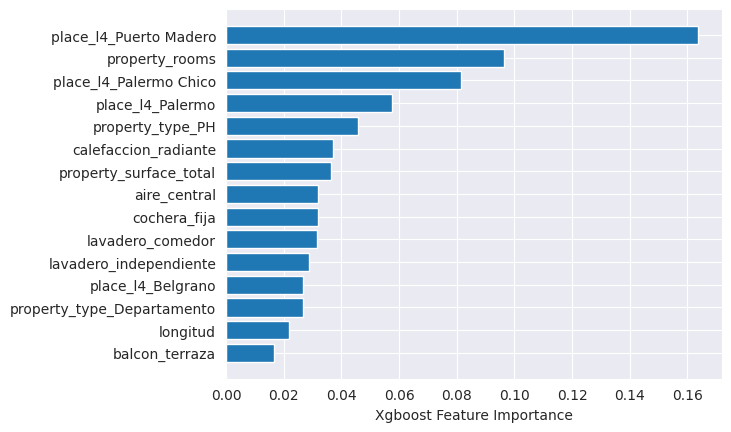

In [67]:
sorted_idx = XGB_Regressor.feature_importances_.argsort()
sorted_idx = sorted_idx[-15:]
plt.barh(df_test_dummies.columns[sorted_idx], XGB_Regressor.feature_importances_[sorted_idx])
a = plt.xlabel("Xgboost Feature Importance")

Podemos observar que el feature más importante es la ubicación en Puerto Madero, seguido de cantidad de habitaciones y ubicación en Palermo Chico.

### Importancia de features por aspecto agregado en el punto 1.a

Aspecto Cocina

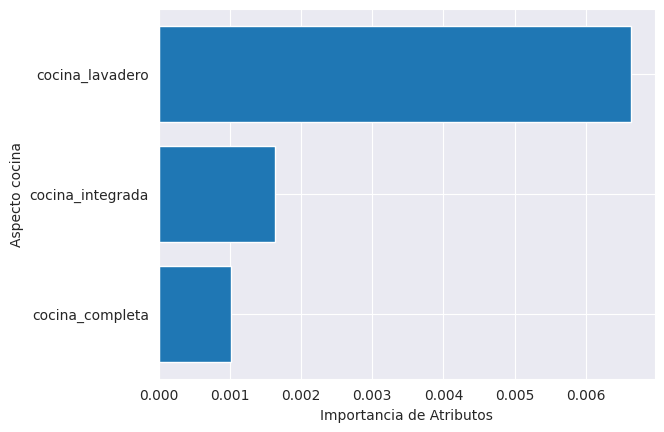

In [68]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cocina_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cocina")

Aspecto Pisos

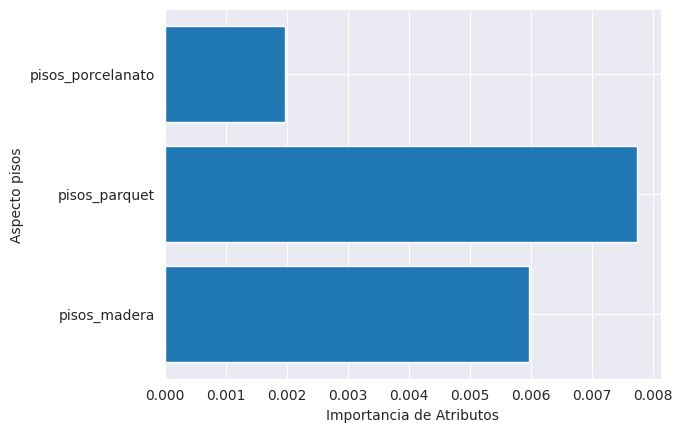

In [69]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('pisos_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto pisos")

Aspecto Calefaccion

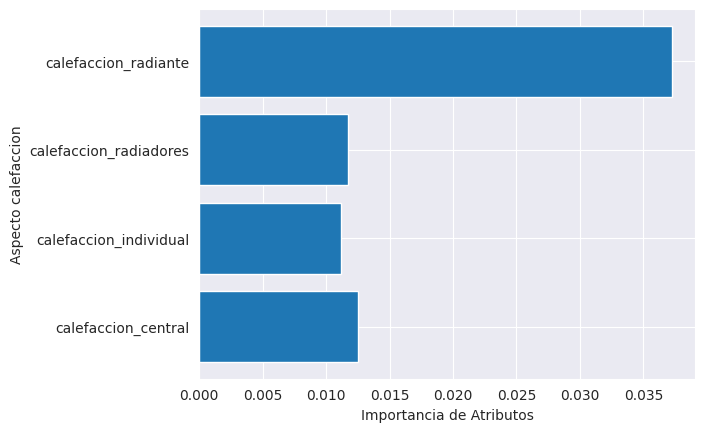

In [70]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('calefaccion_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto calefaccion")

Aspecto Expensas

Text(0, 0.5, 'Aspecto expensas')

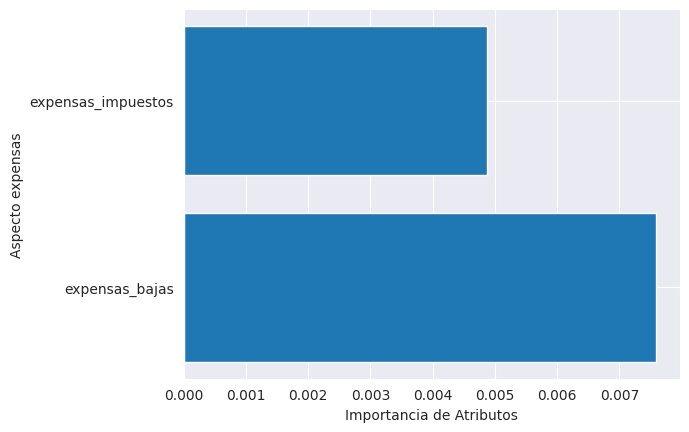

In [71]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('expensas_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto expensas")

Aspecto Lavadero

Text(0, 0.5, 'Aspecto lavadero')

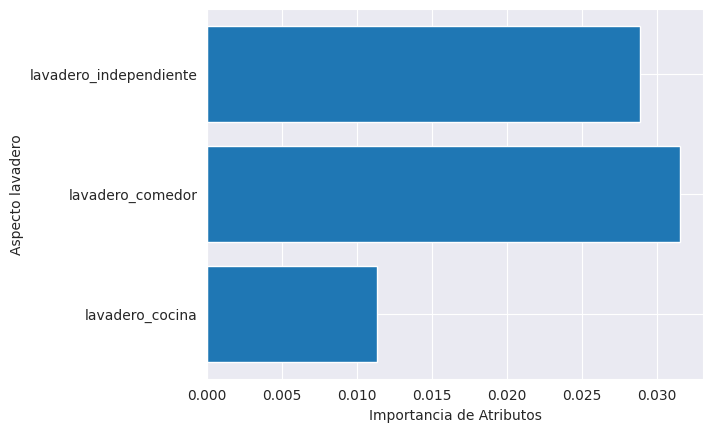

In [72]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('lavadero_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto lavadero")

Aspecto Balcon

Text(0, 0.5, 'Aspecto balcon')

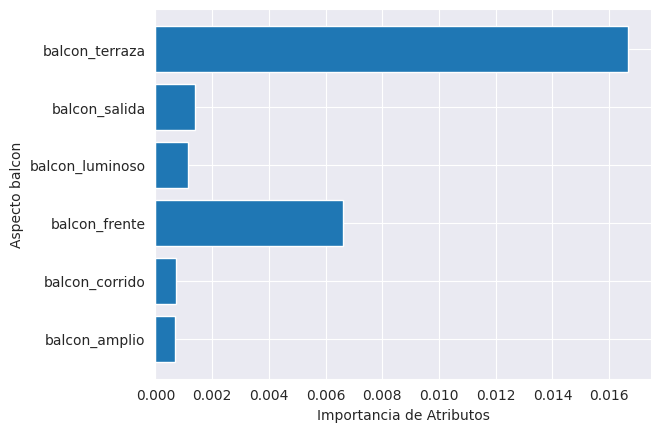

In [73]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('balcon_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto balcon")

Aspecto Cochera

Text(0, 0.5, 'Aspecto cochera')

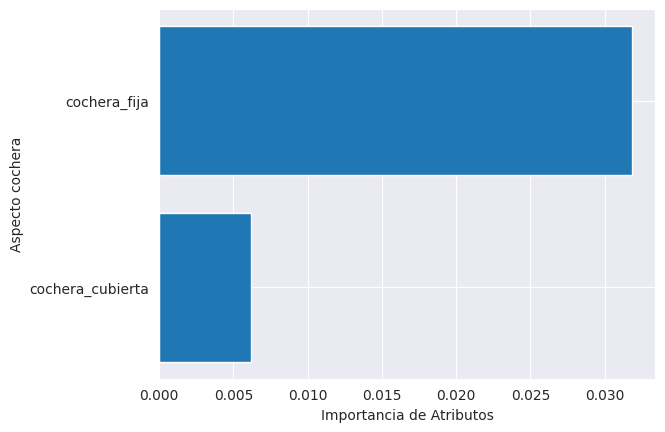

In [74]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cochera_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cochera")

Aspecto Aire

Text(0, 0.5, 'Aspecto aire')

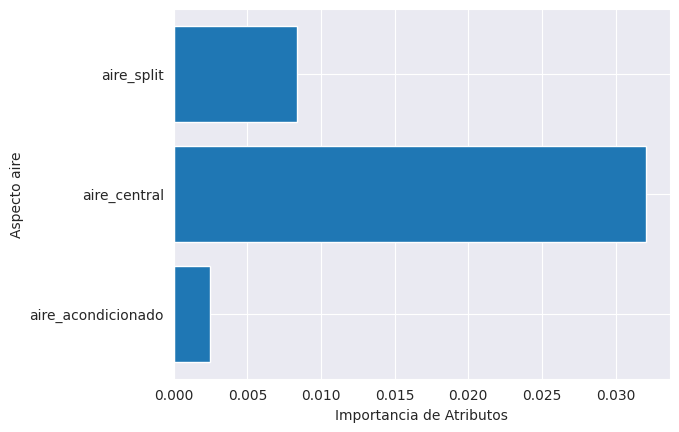

In [75]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('aire_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], XGB_Regressor.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto aire")

## Con optimización de hiperparámetros

Veamos cómo se comporta el score con la optimización de hiperparámetros:

In [94]:
params_grid = {'learning_rate': [0.20, 0.25, 0.30],
               'max_depth': [4, 6, 8, 10],
               'min_child_weight': [1, 3, 5, 7, 9],
               'gamma': [0.1, 0.3, 0.5],
               'colsample_bytree' : [0.3, 0.5, 0.7]}

randomCV = RandomizedSearchCV(estimator = XGBRegressor(),
                              param_distributions = params_grid,
                              scoring = make_scorer(r2_score),
                              cv = 5,
                              n_iter = 20)

randomCV.fit(df_dummies, df_train_y_regresion)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'gamma': [0.1, 0.3, 0.5],
                                        'learning_rate': [0.2, 0.25, 0.3],
                                        'max_depth': [4, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring=make_scorer(r2_score))

In [95]:
randomCV.best_params_

{'min_child_weight': 3,
 'max_depth': 8,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.3}

In [96]:
prediccion_y_metricas_regresion(randomCV.best_estimator_,df_test_dummies, df_test_y_regresion)

Se obtuvo un Score de 58.368%
El error según la métrica 'Mean Square Error' de test es: 52581522459.21658
El error según la métrica 'Root Mean Square Error' de test es: 229306.61233208384


Observamos que, si bien las métricas mejoraron, las diferencias al optimizar los parámetros no fueron muy significativas.

### Importancia de features
Graficamos los 15 features más importantes para el modelo con los hiperparámetros optimizados

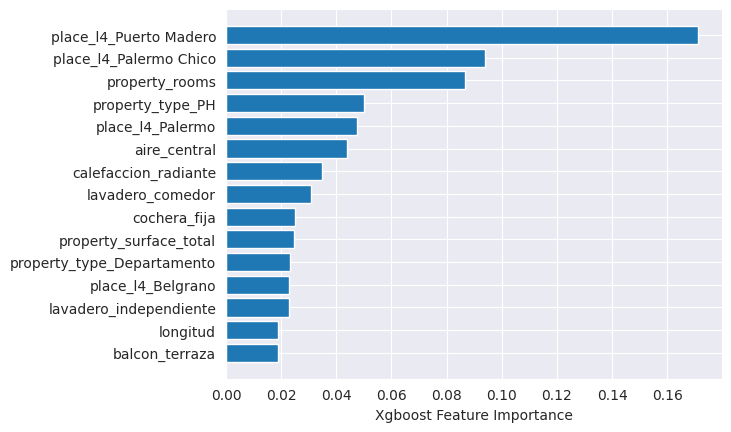

In [97]:
sorted_idx = randomCV.best_estimator_.feature_importances_.argsort()
sorted_idx = sorted_idx[-15:]
plt.barh(df_test_dummies.columns[sorted_idx], randomCV.best_estimator_.feature_importances_[sorted_idx])
a = plt.xlabel("Xgboost Feature Importance")

Podemos ver que la ubicación en Puerto Madero tiene aún más peso que en el modelo anterior y también como algunos de los features con los que expandimos el dataset (calefaccion_radiante y cochera_fija) toman más protagonismo, al igual que la superficie total.

### Importancia de features por aspecto agregado en el punto 1.a

Aspecto Cocina

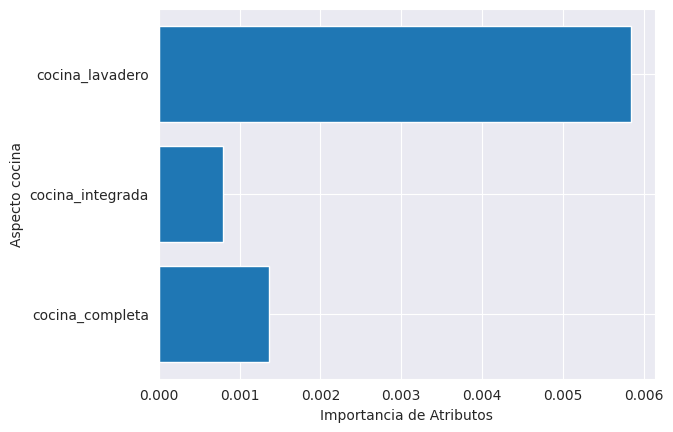

In [98]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cocina_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cocina")

Aspecto Pisos

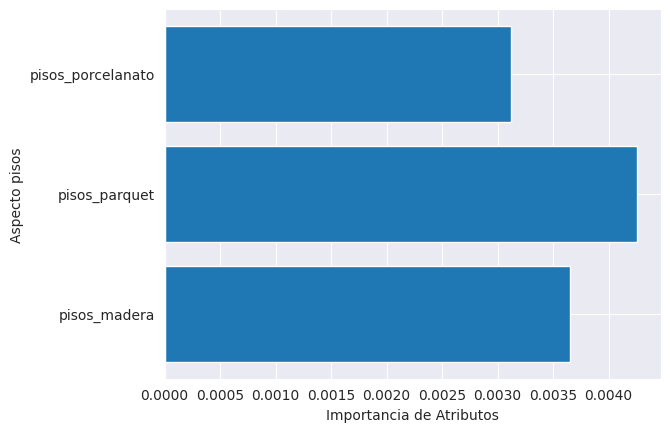

In [99]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('pisos_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto pisos")

Aspecto Calefaccion

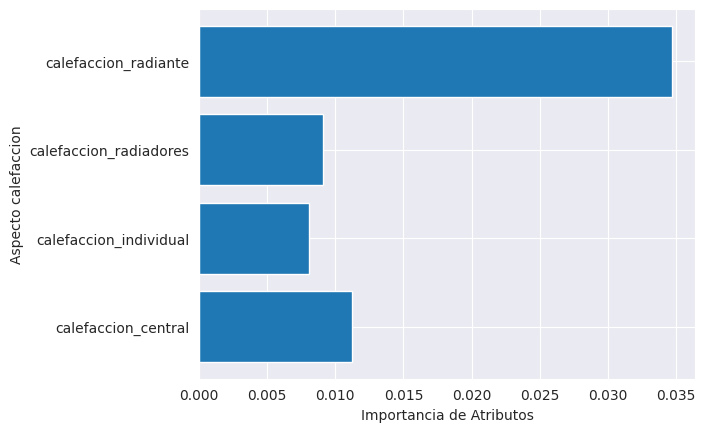

In [100]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('calefaccion_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto calefaccion")

Aspecto Expensas

Text(0, 0.5, 'Aspecto expensas')

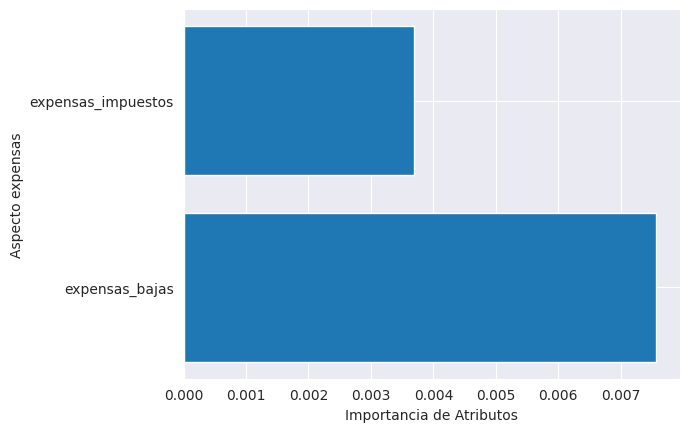

In [101]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('expensas_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto expensas")

Aspecto Lavadero

Text(0, 0.5, 'Aspecto lavadero')

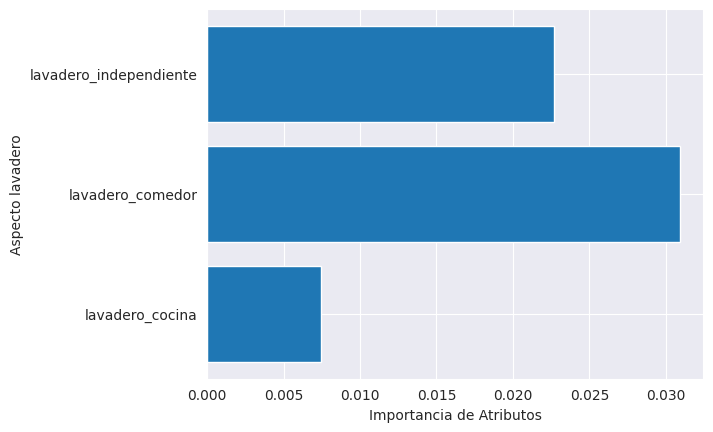

In [102]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('lavadero_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto lavadero")

Aspecto Balcon

Text(0, 0.5, 'Aspecto balcon')

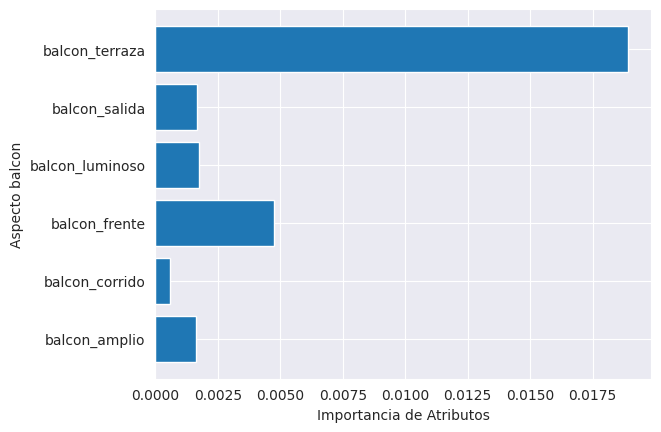

In [103]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('balcon_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto balcon")

Aspecto Cochera

Text(0, 0.5, 'Aspecto cochera')

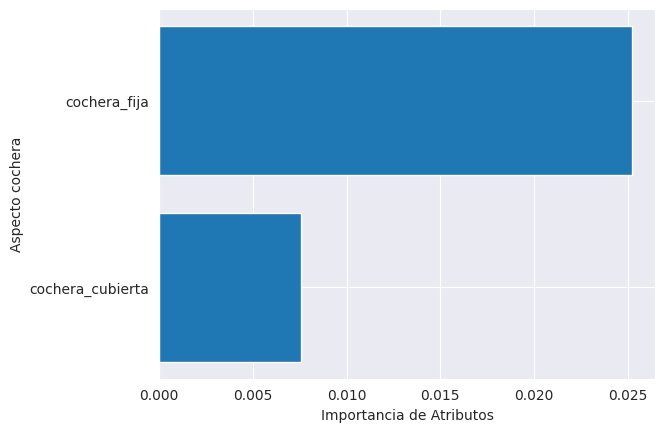

In [104]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('cochera_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto cochera")

Aspecto Aire

Text(0, 0.5, 'Aspecto aire')

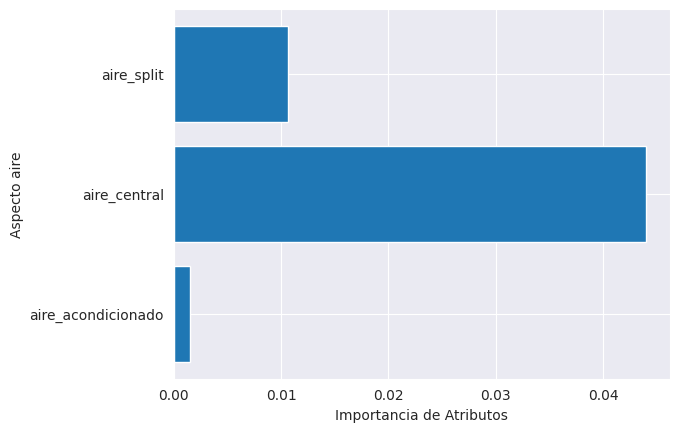

In [105]:
aspecto_id = list()

for aspecto in list(filter(lambda x: x.startswith('aire_'), df_dummies.columns.tolist())):
    aspecto_id.append(df_dummies.columns.get_loc(aspecto))

plt.barh(df_test_dummies.columns[aspecto_id], randomCV.best_estimator_.feature_importances_[aspecto_id])
plt.xlabel("Importancia de Atributos")
a = plt.ylabel("Aspecto aire")

#### Exportación del Modelo
Finalmente exportamos el modelo utilizado para predecir, resultante de la optimización de hiperparámetros:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/XGB_Regressor.json'
else:
  path = './MODELOS/XGB_Regressor.json'

randomCV.best_estimator_.save_model(path)

## 2. Redes Neuronales

### 2.a Regresión

#### 2.a.1 Preparación del dataset

In [ ]:
x_train_regresion = df_train_x.drop(["id"], axis=1).copy()
y_train_regresion = df_train_y_regresion.copy()
x_test_regresion = df_test_x.drop(["id"], axis=1).copy()
y_test_regresion = df_test_y_regresion.copy()

Normalizamos las entradas con StandardScaler:

In [ ]:
x_train_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_regresion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

#### 2.a.2 Búsqueda del mejor modelo

Creo una función que me permite generar un modelo a partir de sus hiperparámetros. Esta función tiene como parámetros la cantidad de nodos de la primera y anteúltima capa, la cantidad de capas ocultas, la función de activación y el optimizador. Todos los modelos que genera a excepción de los casos sin capas ocultas) tienen forma de 'pirámide'.

In [ ]:
cantidad_de_columnas = x_train_regresion.shape[1]

def crear_modelo(hidden_layers, first_layer_nodes, last_layer_nodes, activation_func, optimizer):

    sequential = Sequential()
    sequential.add(keras.layers.Dense(first_layer_nodes, input_shape=(cantidad_de_columnas,), activation='relu'))

    if hidden_layers is 0 or hidden_layers is 1:
        decremento = 0
    else:
        decremento = math.ceil((first_layer_nodes - last_layer_nodes) / (hidden_layers - 1))

    for i in range (0, hidden_layers):
        nodos = first_layer_nodes - decremento * i
        sequential.add(Dense(nodos, activation=activation_func))

    sequential.add(Dense(1, activation='linear'))

    sequential.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mse', 'mean_absolute_percentage_error']
    )

    return sequential


modelo =  KerasRegressor(build_fn=crear_modelo, verbose = False)

Luego busco el mejor modelo a partir de una grilla de parámetros arbitrarios con el método de 'GridSearchCV'. El criterio de mejor modelo es el que tenga menor error cuadrado, o lo que es equivalente, mayor error cuadrado negado. Nos limitamos en la cantidad de folds en el CV por el consumo temporal.

In [ ]:
param_grid = dict(
    hidden_layers=[2, 4],
    first_layer_nodes = [x_train_regresion.shape[1], math.ceil(cantidad_de_columnas * (2/3))],
    last_layer_nodes = [5],
    activation_func = ['sigmoid', 'relu'],
    batch_size = [750],
    epochs = [70],
    optimizer=['RMSprop'],
)

grid = GridSearchCV(
    estimator = modelo,
    param_grid = param_grid,
    cv=5,
    error_score='raise',
    scoring='neg_mean_squared_error',
    verbose=0,
)

Entrenamos todos los modelos

In [ ]:
grid.fit(x_train_regresion, y_train_regresion)

Guardamos el historial de entrenamiento del mejor modelo

In [ ]:
history = grid.best_estimator_.model.history.history

Los parámetros y métricas del mejor modelo fueron:

In [ ]:
print("El error absoluto porcentual promedio del mejor modelo fue de: ", grid.best_estimator_.model.metrics[2].result().numpy())
print("El error absoluto cuadrado promedio del mejor modelo fue de: ", grid.best_estimator_.model.metrics[1].result().numpy())
print("Los parámetros seleccionados por Grid search 5-fold cross validation fueron: ", grid.best_params_)

#### 2.a.3 Predicción

In [ ]:
y_pred = grid.predict(x_test_regresion)

#### 2.a.4 Métricas

Veamos cómo se comporta la función de pérdida del mejor modelo según la cantidad de épocas utilizadas:

In [ ]:
epochs = range(70)
plt.plot(epochs, history['mse'], color='orange', label='MSE')
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title('Error cuadrático medio por cantidad de épocas')
plt.legend()

In [ ]:
mse = metrics.mean_squared_error(
    y_true  = y_test_regresion,
    y_pred  = y_pred,
    squared = True
)

print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

rmse = metrics.mean_squared_error(
    y_true  = y_test_regresion,
    y_pred  = y_pred,
    squared = False
)

print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

r2 = metrics.r2_score(
    y_true  = y_test_regresion,
    y_pred  = y_pred
)

print(f"El error según la métrica 'R2 Score' de test es: {r2}")

#### 2.a.5 Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/Redes_Regressor.joblib'
else:
  path = './MODELOS/Redes_Regressor.joblib'

joblib.dump(grid.best_estimator_.model, path)

### 2.b Clasificación
___

#### 2.b.1 Preparación del dataset

In [ ]:
x_train_clasificacion = df_train_x.drop(["id"], axis=1).copy()
y_train_clasificacion = df_train_y_clasificacion.copy()
x_test_clasificacion = df_test_x.drop(["id"], axis=1).copy()
y_test_clasificacion = df_test_y_clasificacion.copy()

Normalizamos mediante Z-Score:

In [ ]:
x_train_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

Aplicamos One Hot encoding a la columna target de entrenamiento y test, para que tenga 3 columnas al igual que la salida del modelo:

In [ ]:
y_train_clasificacion = pd.get_dummies(y_train_clasificacion, columns=['tipo_precio_3'], drop_first=False)
y_test_clasificacion = pd.get_dummies(y_test_clasificacion, columns=['tipo_precio_3'], drop_first=False)

#### 2.b.2 Búsqueda del mejor modelo

Función auxiliar para que GridSearchCV realice el scoring de forma correcta.

In [ ]:
def my_categorical_accuracy(y_true, y_pred) :
    y_pred_df = pd.DataFrame(data=y_pred, columns=['alto', 'bajo', 'medio'])
    res = round(accuracy_score(y_true, y_pred_df), 2)
    return res

Creamos una función que permite generar un modelo a partir de sus hiperparámetros configurables.
Esta función recibe como parámetros la cantidad de capas ocultas extra, la cantidad de nodos de la última capa oculta, la función de activación y metadata del clasificador.

In [ ]:
def crear_modelo(extra_hidden_layers, last_layer_nodes, activation_func, loss_func, meta):

    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    sequential = Sequential()
    sequential.add(keras.layers.Dense(n_features_in_ * 0.7, input_shape=X_shape_[1:], activation='relu'))

    if last_layer_nodes > n_features_in_:
        decremento = 0
    elif extra_hidden_layers is 0 or extra_hidden_layers is 1:
        decremento = 0
    else:
        decremento = math.ceil((n_features_in_ - last_layer_nodes) / (extra_hidden_layers - 1))

    for i in range (0, extra_hidden_layers):
        nodos = n_features_in_ - decremento * i
        sequential.add(Dense(nodos, activation=activation_func))

    sequential.add(Dense(n_classes_, activation='softmax'))

    sequential.compile(
        loss=loss_func
    )

    return sequential


Creamos un modelo base, necesario según la documentación de SciKeras - KerasClassifier.
Este modelo base será editado por GridSearchCV al buscar los hiperparámetros.

In [ ]:
base_model = KerasClassifier(
    crear_modelo,
    loss_func="categorical_crossentropy",
    extra_hidden_layers=1,
    last_layer_nodes=1,
    activation_func='sigmoid',
)

Definimos los hiperparámetros posibles. Además de los necesarios por la función crear_modelo, agregamos diferentes optimizadores, learning rates y cantidad de épocas.

In [ ]:
param_grid = dict(
    extra_hidden_layers=[1, 4],
    last_layer_nodes = [5, 10, 20],
    activation_func = ['relu', 'softmax'],
    batch_size = [750],
    epochs = [20],
    optimizer__learning_rate = [0.001],
    optimizer = ["adam", "sge"],
    loss_func = ["categorical_crossentropy"],
)

gs = GridSearchCV(base_model,
                  param_grid = param_grid,
                  cv=5,
                  scoring=make_scorer(my_categorical_accuracy),
                  verbose=0,
                  error_score='raise'
)

Entrenamos los diferentes modelos y obtenemos los mejores parámetros.

In [ ]:
gs.fit(x_train_clasificacion, y_train_clasificacion)
print("Los parámetros óptimizados fueron: ", gs.best_params_)

Predecimos con el dataset de test

In [ ]:
y_pr = gs.predict(x_test_clasificacion)

#### 2.b.4 Métricas
Transformamos el array devuelto por el modelo a un dataframe de iguales columnas que y_test_clasificacion

In [ ]:
y_pr_df = pd.DataFrame(data=y_pr, columns=['alto', 'bajo', 'medio'])

Calculamos las métricas

In [ ]:
metricas_clasificacion(y_test_clasificacion, y_pr_df)

#### 2.b.5 Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [ ]:
import joblib

if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/Redes_Classifier.joblib'
else:
  path = './MODELOS/Redes_Classifier.joblib'

joblib.dump(gs.best_estimator_, path)